# ATP Tennis Match Prediction

### ENSAE Python Project - Dejean William, Sala Satorre Daniel, Auvepre Edouard

## Project Objective

Professional tennis is one of the most analyzed sports by bettors and bookmakers. The latter use sophisticated models integrating a multitude of factors to set their odds, which can be considered near-optimal as they reflect aggregated market information.

**Our research question**: using public historical data and an interpretable model, can we identify the key factors determining victory and approach bookmaker performance?

Our approach focuses on a **statistical study of important variables** for tennis match prediction. This is why we chose **logistic regression**: it allows direct interpretation of coefficients and understanding of each variable's influence. More complex models (Random Forest, XGBoost) could potentially offer better performance, but at the expense of interpretability.

**Our working hypotheses**:
- ATP ranking is the best predictor of victory
- Recent performance matters more than distant history (temporal decay)
- The model will be less accurate than bookmakers but could identify market inefficiencies

The ultimate goal is to **compare our model to bookmaker predictions** to evaluate whether our simple approach can detect "value bets" - matches where odds underestimate a player's chances.


  **Notes on structure:**
  - **Data**: CSV files are ignored by git. On first launch, they are downloaded from [TML-Database](https://github.com/Tennismylife/TML-Database) and cached in `data/raw/`. Subsequent runs use the local cache.
  - **Exploration**: The notebook `1_exploration.ipynb` contains our preliminary tests and explorations. It is ignored as non-essential for submission.
  - **Training**: The folder only contains `models.py` for now. This structure allows easy addition of other models and a training script for more complex models.
  - **Data/processed**: The `data/processed/` and `data/preprocessing/` folders are not created as the submission is a single notebook. The structure nevertheless allows saving pre-processed data (in parquet format) and the preprocessor for future reuse.

---

## Notebook Structure

1. **Loading and exploring raw data**
2. **Preprocessing and feature engineering**
3. **In-depth feature analysis**
4. **Modeling and evaluation**

---

## Code Organization

Reusable functions are organized in `src/` folders:

**Preprocessing** (`src/preprocessing/`):
- `cleaning.py`: data loading and cleaning
- `features.py`: feature creation (Elo, historical stats, temporal decay)
- `pipeline.py`: preprocessing orchestration with the `TennisPreprocessor` class

**Modeling** (`src/training/`):
- `models.py`: model definitions, notably `StatsLogitClassifier` (statsmodels wrapper compatible with scikit-learn)

**Evaluation** (`src/evaluation/`):
- `bookmakers.py`: odds loading from tennis-data.co.uk and matching with our data
- `comparison.py`: model vs bookmakers comparison functions (ROI, value bets, accuracy)

This modular structure keeps the notebook readable by directly importing functions, and facilitates code reuse.

---

# Part 1: Loading and Exploring Raw Data

## 1.1 Imports and Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

# Add src/ to path to import our modules
sys.path.append(str(Path.cwd().parent / 'src'))

# Import the preprocessor
from preprocessing.pipeline import TennisPreprocessor
from config import N_HISTORICAL_MATCHES, N_SURFACE_MATCHES, HALF_LIFE_DAYS, RANDOM_STATE

# Display configuration
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Instantiate the preprocessor
preprocessor = TennisPreprocessor()

## 1.2 Loading the Data

This dataset comes from [TML-Database](https://github.com/Tennismylife/TML-Database), maintained by the tennis community. It compiles official ATP data and serves as a reference for professional tennis statistical analysis.

We use the `load_matches()` function from our `src/preprocessing/cleaning.py` module which automatically downloads CSV files from GitHub and caches them locally.

In [2]:
from preprocessing.cleaning import load_matches
from config import RAW_DIR

# Load all data (2000-2025)
matches = load_matches(raw_dir=RAW_DIR)
print(f"Total number of matches: {len(matches):,}")

Total number of matches: 77,954


## 1.3 Data Overview

Let's look at the data structure to understand what we have available.

In [3]:
# Display available columns
print("Available columns:")
print(matches.columns.tolist())

Available columns:
['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level', 'indoor', 'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry', 'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age', 'winner_rank', 'winner_rank_points', 'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age', 'loser_rank', 'loser_rank_points', 'score', 'best_of', 'round', 'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced']


In [4]:
# Aperçu des premières lignes
matches.head(3)

,tourney_id,tourney_name,surface,draw_size,tourney_level,indoor,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced
0,2000-7308,Adelaide,Hard,32.0,250,O,20000103,1.0,E113,1.0,NaN,Thomas Enqvist,R,191.0,SWE,25.810,4.0,2606.0,C487,NaN,NaN,Arnaud Clement,R,173.0,FRA,22.045,56.0,805.0,6-3 6-4,3,R32,76.0,6.0,0.0,66.0,29.0,23.0,23.0,10.0,2.0,2.0,1.0,3.0,59.0,37.0,25.0,13.0,9.0,2.0,4.0
1,2000-7308,Adelaide,Hard,32.0,250,O,20000103,2.0,F324,NaN,NaN,Roger Federer,R,185.0,SUI,18.404,64.0,749.0,K260,NaN,NaN,Jens Knippschild,R,191.0,GER,24.882,91.0,525.0,6-1 6-4,3,R32,45.0,6.0,3.0,46.0,28.0,24.0,12.0,9.0,0.0,0.0,3.0,5.0,42.0,15.0,13.0,12.0,8.0,0.0,3.0
2,2000-7308,Adelaide,Hard,32.0,250,O,20000103,3.0,G352,NaN,NaN,Jan-Michael Gambill,R,191.0,USA,22.585,58.0,803.0,A202,NaN,NaN,Wayne Arthurs,L,185.0,AUS,28.797,105.0,449.0,3-6 7-6(5) 6-4,3,R32,115.0,8.0,3.0,81.0,40.0,35.0,28.0,15.0,0.0,1.0,26.0,2.0,103.0,59.0,49.0,22.0,16.0,4.0,5.0


### Observations on Data Structure

Each row represents a match with:

**Tournament information:**
- `tourney_name`, `tourney_date`: tournament name and date
- `surface`: surface type (Hard, Clay, Grass, Carpet)
- `tourney_level`: tournament level (G=Grand Slam, M=Masters, A=ATP 250/500, etc.)
- `round`: tournament round (R128, R64, R32, R16, QF, SF, F)

**Player information:**
- `winner_*` / `loser_*`: winner and loser information
- `_rank`, `_rank_points`: ATP ranking and points
- `_age`, `_ht`, `_hand`: age, height, dominant hand

**Match statistics:**
- `w_ace`, `w_df`, `w_svpt`, etc.: winner's service statistics
- `l_ace`, `l_df`, `l_svpt`, etc.: loser's service statistics

We will thus attempt to understand the impact of different variables on whether a player wins or not, in order to best predict match outcomes.

## 1.4 Missing Values Analysis

Before any preprocessing, let's identify columns with missing values.

In [5]:
# Pourcentage de valeurs manquantes par colonne
missing = (matches.isnull().sum() / len(matches) * 100).sort_values(ascending=False)
missing_df = missing[missing > 0].reset_index()
missing_df.columns = ['Column', '% Missing']
missing_df['% Missing'] = missing_df['% Missing'].round(2)
missing_df

,Column,% Missing
0,winner_entry,87.57
1,loser_entry,79.96
2,loser_seed,77.05
3,winner_seed,58.63
4,minutes,9.28
5,indoor,8.82
6,l_ace,8.24
7,w_bpFaced,8.24
8,w_bpSaved,8.24
9,w_SvGms,8.24


### Observations on Missing Values

- **`winner_entry`, `loser_entry`, `winner_seed`, `loser_seed`**: These columns are only filled for seeded players. This is not problematic as we won't use these variables.

- **Match statistics (`w_ace`, `l_df`, etc.)**: ~4-5% of matches without statistics (probably matches where stats weren't recorded). These matches can be kept as we'll calculate historical statistics. This will limit historical feature calculation for some less prominent players, for whom we'll use default values based on their ranking.

- **`winner_rank`, `loser_rank`**: <1% missing values. We'll impute with a default value (high rank).

- **`winner_ht`, `loser_ht`**: <1% missing heights. We'll impute with the median.

## 1.5 Incomplete Matches Analysis

Some matches end by retirement (RET), walkover (W/O), or disqualification (DEF). These matches may not reflect players' true levels and could therefore limit our prediction accuracy.

In [6]:
# Identify incomplete matches via score
incomplete_patterns = ['RET', 'W/O', 'DEF', 'Walkover', 'Default']
is_incomplete = matches['score'].fillna('').str.contains('|'.join(incomplete_patterns), case=False)

n_incomplete = is_incomplete.sum()
pct_incomplete = n_incomplete / len(matches) * 100

print(f"Incomplete matches: {n_incomplete:,} ({pct_incomplete:.2f}%)")
print("\nExamples of incomplete scores:")
matches.loc[is_incomplete, 'score'].head(10).tolist()

Incomplete matches: 2,788 (3.58%)

Examples of incomplete scores:


['6-4 0-1 RET',
 '6-1 RET',
 '3-6 7-5 3-0 RET',
 '7-5 3-6 1-0 RET',
 '7-6(2) 6-4 RET',
 '6-2 4-1 RET',
 '3-6 7-6(3) 6-2 4-1 RET',
 '6-4 6-4 3-6 3-1 RET',
 '6-2 2-6 6-4 3-1 RET',
 '6-0 6-7(2) 3-1 RET']

**Decision**: We remove matches ending by retirement or walkover (W/O, RET). These matches don't reflect the true confrontation between players: a player may retire while leading, or be forced to withdraw before even playing. Including them would skew the analysis of victory factors.

## 1.6 Surface Distribution

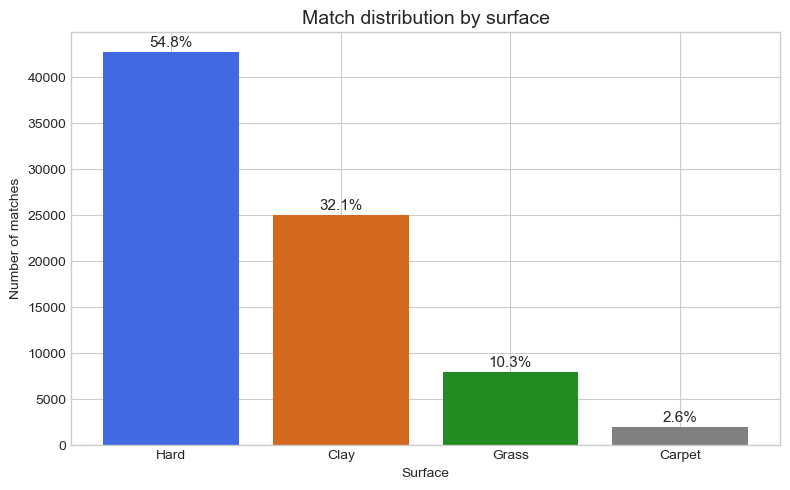

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))

colors = {'Hard': '#4169E1', 'Clay': '#D2691E', 'Grass': '#228B22', 'Carpet': '#808080'}
surface_counts = matches['surface'].value_counts()

bars = ax.bar(surface_counts.index, surface_counts.values, 
              color=[colors.get(s, '#808080') for s in surface_counts.index])

ax.set_title('Match distribution by surface', fontsize=14)
ax.set_xlabel('Surface')
ax.set_ylabel('Number of matches')

# Add percentages
for bar, count in zip(bars, surface_counts.values):
    pct = count / len(matches) * 100
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, 
            f'{pct:.1f}%', ha='center', fontsize=11)

plt.tight_layout()
plt.show()

**Observation**: Hard court is the dominant surface (~60%), followed by clay (~30%) and grass (~10%). Carpet has virtually disappeared from the circuit. Studying the playing surface will also allow us to confirm or refute the widespread belief about its major role in match outcomes (some players being specialists on certain surfaces).

## 1.7 The Baseline: Does the Better Ranked Player Always Win?

We can intuitively think that the better ranked player tends to win in most cases. Let's calculate the win rate of the better ranked player. This is our **baseline to beat**. This means our model must provide more accuracy than simple ranking - otherwise it wouldn't be useful.

In [8]:
# Filter matches with available rankings
matches_with_ranks = matches.dropna(subset=['winner_rank', 'loser_rank'])

# Better ranked = the one with the lower rank
better_ranked_wins = (matches_with_ranks['winner_rank'] < matches_with_ranks['loser_rank']).mean()

print(f"The better ranked player wins: {better_ranked_wins:.1%} of matches")
print(f"\n-> This is our BASELINE to beat!")

The better ranked player wins: 65.4% of matches

-> This is our BASELINE to beat!


## 1.8 Ranking Distribution

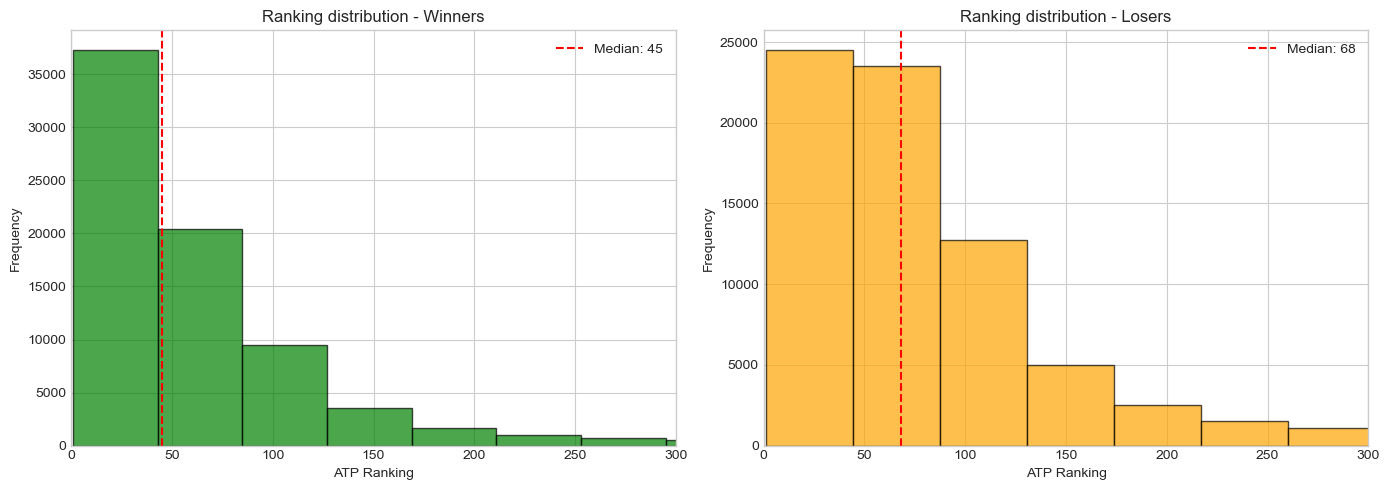

Median ranking of winners: 45
Median ranking of losers: 68


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Winners' ranking
axes[0].hist(matches['winner_rank'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0].set_title('Ranking distribution - Winners', fontsize=12)
axes[0].set_xlabel('ATP Ranking')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(0, 300)
axes[0].axvline(matches['winner_rank'].median(), color='red', linestyle='--', label=f"Median: {matches['winner_rank'].median():.0f}")
axes[0].legend()

# Losers' ranking
axes[1].hist(matches['loser_rank'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Ranking distribution - Losers', fontsize=12)
axes[1].set_xlabel('ATP Ranking')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(0, 300)
axes[1].axvline(matches['loser_rank'].median(), color='red', linestyle='--', label=f"Median: {matches['loser_rank'].median():.0f}")
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Median ranking of winners: {matches['winner_rank'].median():.0f}")
print(f"Median ranking of losers: {matches['loser_rank'].median():.0f}")

**Observation**: Winners have better rankings than losers:
- Median winner ranking: **45**
- Median loser ranking: **68**

This confirms the importance of ranking as a predictive variable.

## 1.9 Tournament Levels

In [10]:
# Decode tournament levels
level_names = {
    'G': 'Grand Slam',
    'M': 'Masters 1000',
    'A': 'ATP 250/500',
    'D': 'Davis Cup',
    'F': 'ATP Finals',
    'O': 'Olympics'
}

level_counts = matches['tourney_level'].value_counts()
level_df = pd.DataFrame({
    'Level': [level_names.get(l, l) for l in level_counts.index],
    'Code': level_counts.index,
    'Number of matches': level_counts.values,
    '%': (level_counts.values / len(matches) * 100).round(1)
})
level_df

,Level,Code,Number of matches,%
0,250,250,30706,39.4
1,Masters 1000,M,14774,19.0
2,Grand Slam,G,13081,16.8
3,500,500,10378,13.3
4,Davis Cup,D,7331,9.4
5,ATP 250/500,A,830,1.1
6,Olympics,O,448,0.6
7,ATP Finals,F,406,0.5


We can see that the diversity of tournaments will allow for comprehensive predictions.

---

## 1.10 Exploration Conclusion

### What we learned:

1. **77,939 matches** over 25 years of ATP data (2000-2025)
2. **Baseline**: the better ranked player wins **65.4%** of the time
3. **Surfaces**: Hard dominates (60%), followed by Clay (30%) and Grass (10%)
4. **Missing values**: not problematic (<5% for important variables)
5. **Incomplete matches**: 2,788 matches (~3.6%) to remove (RET, W/O, DEF)

---

# Part 2: Preprocessing and Feature Engineering

In this part, we will:
1. Clean the raw data
2. Create relevant features to predict the winner
3. Apply temporal decay to weight recent matches

## 2.1 Data Cleaning

We use the `clean_matches()` function from `src/preprocessing/cleaning.py` which performs the following operations:

1. **Removal of incomplete matches**: RET, W/O, DEF
2. **Date conversion**: datetime format
3. **Missing ranking imputation**: max rank + 50
4. **Missing physical data imputation**: median for height and age
5. **Filter significant rounds**: R128, R64, R32, R16, QF, SF, F, RR

In [11]:
from preprocessing.cleaning import clean_matches

# Apply cleaning
matches_clean = clean_matches(matches)

print(f"Before cleaning: {len(matches):,} matches")
print(f"After cleaning: {len(matches_clean):,} matches")
print(f"Matches removed: {len(matches) - len(matches_clean):,} ({(len(matches) - len(matches_clean)) / len(matches) * 100:.1f}%)")

Before cleaning: 77,954 matches
After cleaning: 75,023 matches
Matches removed: 2,931 (3.8%)


In [12]:
# Verify no more missing values in key columns
key_cols = ['winner_rank', 'loser_rank', 'winner_age', 'loser_age', 'winner_ht', 'loser_ht', 'tourney_date']
print("Missing values in key columns after cleaning:")
print(matches_clean[key_cols].isnull().sum())

Missing values in key columns after cleaning:
winner_rank     0
loser_rank      0
winner_age      0
loser_age       0
winner_ht       0
loser_ht        0
tourney_date    0
dtype: int64


This cleaning gives us data ready for use. We now need to think about how to make them as relevant as possible to optimize our model's accuracy.

## 2.2 Feature Engineering: Conceptual Approach

### The Challenge of Tennis Match Prediction

To predict the winner of a match, we must transform raw data into features comparing the two players.

**Problem**: Data is in `winner_*` / `loser_*` format, which creates bias (the winner always has better stats in the match). The winner_* / loser_* format indeed introduces structural bias as it implicitly encodes the match outcome. Without randomization, the model learns to identify the winner from position in the dataset rather than from players' intrinsic characteristics.

**Solution**: We randomize player assignment to `player_a` / `player_b` and use only **statistics calculated BEFORE the match** (history of previous matches) to avoid this bias.

### Types of Features Created

| Category | Features | Description |
|----------|----------|-------------|
| **Static** | `rank_a`, `rank_b`, `points_a`, `points_b` | ATP ranking and points at match time |
| **Elo** | `elo_a`, `elo_b`, `elo_surface_a`, `elo_surface_b` | Global and surface Elo ratings, updated after each match |
| **Physical** | `age_a`, `age_b`, `height_a`, `height_b`, `is_left_a`, `is_left_b` | Physical characteristics |
| **Historical** | `win_rate_a`, `ace_rate_a`, `df_rate_a`, etc. | Stats calculated on last N matches with temporal decay |
| **Surface** | `surface_win_rate_a`, `surface_win_rate_b` | Win rate specific to the surface |
| **Head-to-head** | `h2h_win_rate_a` | Direct confrontation history |
| **Contextual** | `surface`, `tourney_level`, `best_of_5`, `round` | Match information |
| **Ratio** | `rank_ratio` | Ranking ratio (captures non-linearity) |

The surface-specific win rate will introduce in our model the idea that beyond their general level, players often have a preferred surface. The head-to-head history will introduce the idea that despite level differences, there are psychological advantages linked to previous encounters, rivalries that make certain matches closer, etc.

### Temporal Decay

Recent matches are more informative than old ones. We apply an **exponential decay** with a half-life of 180 days:

$$w_i = e^{-\frac{\Delta t_i}{\text{half\_life}}}$$

Thus, with `half_life = 180 days` (chosen empirically), a match played 180 days ago counts for 50% of a match played today. Indeed, in tennis, current form is very important and a player's results are poorly correlated with results from 5 years ago.

### The Elo Rating

The Elo system, originally designed for chess, estimates a player's level dynamically. Unlike ATP ranking (updated weekly), Elo is recalculated **after each match**.

**Principle:** When a player wins, they gain Elo points. When they lose, they lose points. The number of points exchanged depends on the level difference between the two players: beating a higher-ranked opponent earns more points than beating a weaker opponent.

**Update formula:**

After a match between A and B, A's new Elo is:

$$Elo_A^{new} = Elo_A + K \times (R - E_A)$$

where:
- $K$: sensitivity factor (we use $K = 32$)
- $R$: match result (1 if A wins, 0 if A loses)
- $E_A$: A's expected win probability, calculated as:

$$E_A = \frac{1}{1 + 10^{(Elo_B - Elo_A) / 400}}$$

**Example:** If A (Elo 1600) beats B (Elo 1800), the victory was unexpected ($E_A \approx 0.24$), so A gains many points: $32 \times (1 - 0.24) \approx +24$ points.

## 2.3 Building Player History

Before creating features, we build a dictionary containing each player's complete history. This allows quick calculation of statistics for any match.

We use the `preprocessor.build_history()` method which iterates through all matches and stores for each player:
- Match date
- Surface
- Opponent
- Result (win/loss)
- Service statistics (aces, double faults, etc.)

### Handling Players Without History

For players without sufficient history in our dataset (new to the circuit, missing data), we assign **default statistics based on their ATP ranking**. The hypothesis is that a Top 10 player has on average better statistics than a player ranked beyond Top 100. These default values were chosen empirically by observing averages by ranking tier.

In [13]:
# Build history for all players via the preprocessor
player_history = preprocessor.build_history(matches_clean)

# Statistics on history
n_players = len(player_history)
avg_matches = np.mean([len(h) for h in player_history.values()])

print(f"Number of unique players: {n_players:,}")
print(f"Nombre moyen de matches par joueur : {avg_matches:.1f}")

Number of unique players: 2,706
Nombre moyen de matches par joueur : 55.4


In [14]:
# Example: a player's history (Nadal - ID 104745)
nadal_id = 'N409'
if nadal_id in player_history:
    print(f"Exemple : 3 derniers matches de Nadal dans l'historique\n")
    for match in player_history[nadal_id][-3:]:
        print(f"  Date: {match['date']}, Surface: {match['surface']}, "
              f"Win: {'Yes' if match['won'] else 'No'}, Aces: {match.get('ace', 'N/A')}")

Exemple : 3 derniers matches de Nadal dans l'historique

  Date: 2024-07-29 00:00:00, Surface: Clay, Win: Yes, Aces: 1.0
  Date: 2024-07-29 00:00:00, Surface: Clay, Win: No, Aces: 1.0
  Date: 2024-11-19 00:00:00, Surface: Hard, Win: No, Aces: 2.0


## 2.4 Feature Creation

We use the `preprocessor.create_features()` method which:

1. **Randomizes** winner/loser assignment -> player_a/player_b
2. **Extracts** static features (rank, points, age, height)
3. **Calculates** historical features with temporal decay
4. **Creates** the target variable: `target = 1` if player_a wins, `0` otherwise
5. **Preserves** match information (player names, date) for bookmaker comparison

### Preprocessor Parameters

| Parameter | Value | Description |
|-----------|-------|-------------|
| `n_hist` | 10 | Number of matches for general stats |
| `n_surf` | 20 | Number of matches for surface stats |
| `half_life_days` | 180 | Temporal decay half-life (in days) |
| `base_rating` | 1500 | Initial ELO rating for each player |
| `k` | 32 | ELO K-factor (adjustment speed) |
| `surface_factor` | 0.5 | K-factor for surface ELO (k x 0.5 = 16) |

### Elo vs ATP Ranking: Two Complementary Measures

- **ATP Ranking**: cumulative points over 52 rolling weeks. Stable measure but not very reactive to recent form changes. An injured player keeps their ranking for 3 months.

- **Elo**: updated after each match based on result and opponent strength. More reactive to recent performance but potentially more volatile.

We also calculate a **surface Elo** because some players have very different performances depending on the court (e.g., clay court specialists vs grass).

The k-factors allow modeling the adjustment speed of players' ELO based on their performance, higher or lower depending on ranking. We also account for ELO by playing surface. In tennis, the base ELO is 1500.

In [15]:
# Create features via the preprocessor
print("Creating features...")
features_df = preprocessor.create_features(matches_clean)

print(f"\nDataset created: {features_df.shape[0]:,} matches × {features_df.shape[1]} columns")

Creating features...

Dataset created: 75,023 matches × 40 columns


In [16]:
# Overview of created features
print("Features created:")
print(features_df.columns.tolist())

Features created:
['tourney_date', 'target', 'rank_a', 'rank_b', 'points_a', 'points_b', 'elo_a', 'elo_b', 'elo_surface_a', 'elo_surface_b', 'age_a', 'age_b', 'height_a', 'height_b', 'is_left_a', 'is_left_b', 'surface', 'tourney_level', 'best_of_5', 'round', 'rank_ratio', 'win_rate_a', 'ace_rate_a', 'df_rate_a', 'first_serve_pct_a', 'first_serve_won_a', 'second_serve_won_a', 'bp_save_rate_a', 'matches_played_a', 'win_rate_b', 'ace_rate_b', 'df_rate_b', 'first_serve_pct_b', 'first_serve_won_b', 'second_serve_won_b', 'bp_save_rate_b', 'matches_played_b', 'surface_win_rate_a', 'surface_win_rate_b', 'h2h_win_rate_a']


In [17]:
# Aperçu des premières lignes
features_df.head()

,tourney_date,target,rank_a,rank_b,points_a,points_b,elo_a,elo_b,elo_surface_a,elo_surface_b,age_a,age_b,height_a,height_b,is_left_a,is_left_b,surface,tourney_level,best_of_5,round,rank_ratio,win_rate_a,ace_rate_a,df_rate_a,first_serve_pct_a,first_serve_won_a,second_serve_won_a,bp_save_rate_a,matches_played_a,win_rate_b,ace_rate_b,df_rate_b,first_serve_pct_b,first_serve_won_b,second_serve_won_b,bp_save_rate_b,matches_played_b,surface_win_rate_a,surface_win_rate_b,h2h_win_rate_a
0,2000-01-03,0,56.0,4.0,805.0,2606.0,1500.000000,1500.0,1500.000000,1500.0,22.045,25.810,173.0,191.0,0,0,Hard,250,0,R32,14.000000,0.50,0.05,0.03,0.60,0.70,0.50,0.60,0,0.70,0.08,0.02,0.65,0.75,0.55,0.65,0,0.5,0.5,0.5
1,2000-01-03,1,64.0,91.0,749.0,525.0,1484.736307,1500.0,1492.184174,1500.0,18.404,24.882,185.0,191.0,0,0,Hard,250,0,R32,0.703297,0.50,0.05,0.03,0.60,0.70,0.50,0.60,0,0.50,0.05,0.03,0.60,0.70,0.50,0.60,0,0.5,0.5,0.5
2,2000-01-03,0,105.0,58.0,449.0,803.0,1500.000000,1484.0,1500.000000,1492.0,28.797,22.585,185.0,191.0,1,0,Hard,250,0,R32,1.810345,0.45,0.04,0.04,0.58,0.68,0.48,0.58,0,0.50,0.05,0.03,0.60,0.70,0.50,0.60,0,0.5,0.5,0.5
3,2000-01-03,0,54.0,27.0,845.0,1298.0,1500.000000,1516.0,1500.000000,1508.0,23.710,21.599,180.0,175.0,0,0,Hard,250,0,R32,2.000000,0.50,0.05,0.03,0.60,0.70,0.50,0.60,0,0.55,0.06,0.03,0.62,0.72,0.52,0.62,0,0.5,0.5,0.5
4,2000-01-03,1,15.0,154.0,1748.0,297.0,1516.000000,1500.0,1508.000000,1500.0,23.595,25.580,188.0,175.0,0,1,Hard,250,0,R32,0.097403,0.55,0.06,0.03,0.62,0.72,0.52,0.62,0,0.45,0.04,0.04,0.58,0.68,0.48,0.58,0,0.5,0.5,0.5


### Description of Created Features

| Feature | Description |
|---------|-------------|
| `target` | Target variable: 1 if player_a wins, 0 otherwise |
| `rank_a`, `rank_b` | Players' ATP ranking |
| `points_a`, `points_b` | Players' ATP points |
| `elo_a`, `elo_b` | Players' global Elo score (dynamically calculated) |
| `elo_surface_a`, `elo_surface_b` | Surface-specific Elo score |
| `age_a`, `age_b` | Players' age |
| `height_a`, `height_b` | Players' height (cm) |
| `is_left_a`, `is_left_b` | 1 if left-handed, 0 if right-handed |
| `rank_ratio` | `rank_a / rank_b` (non-linear ratio) |
| `win_rate_a`, `win_rate_b` | Weighted win rate (last 10 matches) |
| `ace_rate_a`, `ace_rate_b` | Aces per service point |
| `df_rate_a`, `df_rate_b` | Double faults per service point |
| `first_serve_pct_a/b` | % of first serves in |
| `first_serve_won_a/b` | % of points won on 1st serve |
| `second_serve_won_a/b` | % of points won on 2nd serve |
| `bp_save_rate_a/b` | % of break points saved |
| `matches_played_a/b` | Number of recent matches (experience) |
| `surface_win_rate_a/b` | Win rate on match surface |
| `h2h_win_rate_a` | A's win % against B (history) |
| `surface` | Surface type (Hard, Clay, Grass) |
| `tourney_level` | Tournament level (G, M, 500, 250, etc.) |
| `round` | Tournament round (R128, R64, ..., F) |
| `best_of_5` | 1 if best-of-5 match, 0 if best-of-3 |

The target variable is what we will try to predict from the other variables.

## 2.5 Target Variable Verification

Thanks to player_a/player_b randomization, the target variable should be balanced (~50/50). Indeed, we should have as many player_a winners as player_b winners - that's the whole point of this randomization.

In [18]:
# Check target variable balance
target_counts = features_df['target'].value_counts()
print("Target variable distribution:")
print(f"  Player A wins (target=1): {target_counts.get(1, 0):,} ({target_counts.get(1, 0) / len(features_df) * 100:.1f}%)")
print(f"  Player B wins (target=0): {target_counts.get(0, 0):,} ({target_counts.get(0, 0) / len(features_df) * 100:.1f}%)")
print(f"\n✓ Randomization works correctly: classes are balanced.")

Target variable distribution:
  Player A wins (target=1): 37,300 (49.7%)
  Player B wins (target=0): 37,723 (50.3%)

✓ Randomization works correctly: classes are balanced.


## 2.6 Categorical Variable Encoding

Categorical variables (`surface`, `tourney_level`, `round`) must be encoded as numeric variables to be used correctly.

We use the `preprocessor.encode()` method from our `TennisPreprocessor` class which applies **one-hot encoding** with `drop_first=True` to avoid perfect multicollinearity (dummy variable trap).

For example, for `surface` with 4 categories (Carpet, Clay, Grass, Hard):
- We create 3 binary columns: `surface_Clay`, `surface_Grass`, `surface_Hard`
- `Carpet` becomes the reference category (all columns = 0)

In [19]:
# Apply one-hot encoding via the preprocessor
features_encoded = preprocessor.encode(features_df)

print(f"After encoding: {features_encoded.shape[1]} columns")
print(f"\nNouvelles columns créées :")
categorical_cols = ['surface', 'tourney_level', 'round']
new_cols = [c for c in features_encoded.columns if any(c.startswith(p + '_') for p in categorical_cols)]
print(new_cols)

After encoding: 54 columns

Nouvelles columns créées :
['surface_win_rate_a', 'surface_win_rate_b', 'surface_Clay', 'surface_Grass', 'surface_Hard', 'tourney_level_500', 'tourney_level_A', 'tourney_level_D', 'tourney_level_F', 'tourney_level_G', 'tourney_level_M', 'tourney_level_O', 'round_QF', 'round_R128', 'round_R16', 'round_R32', 'round_R64', 'round_RR', 'round_SF']


## 2.7 Final Data Verification

In [20]:
# Check for missing values
missing_count = features_encoded.isnull().sum().sum()
print(f"Total missing values: {missing_count}")

# Check data types
print(f"\nData types:")
print(features_encoded.dtypes.value_counts())

Total missing values: 0

Data types:
float64           30
bool              17
int64              6
datetime64[ns]     1
Name: count, dtype: int64


In [21]:
# Descriptive statistics of main numerical features
main_features = ['rank_a', 'rank_b', 'points_a', 'points_b', 'win_rate_a', 'win_rate_b', 
                 'surface_win_rate_a', 'surface_win_rate_b', 'h2h_win_rate_a', 'elo_a', 'elo_b']
features_encoded[main_features].describe().round(3)

,rank_a,rank_b,points_a,points_b,win_rate_a,win_rate_b,surface_win_rate_a,surface_win_rate_b,h2h_win_rate_a,elo_a,elo_b
count,75023.000,75023.000,75023.000,75023.000,75023.000,75023.000,75023.000,75023.000,75023.000,75023.000,75023.000
mean,127.304,127.081,1277.429,1298.217,0.471,0.472,0.481,0.481,0.500,1663.153,1663.875
std,294.837,295.113,1635.338,1685.271,0.210,0.210,0.218,0.218,0.307,165.856,167.128
min,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1299.584,1306.935
25%,26.000,26.000,482.000,486.000,0.331,0.332,0.363,0.364,0.500,1531.523,1531.505
50%,57.000,57.000,805.000,810.000,0.486,0.486,0.500,0.500,0.500,1636.108,1637.551
75%,103.000,102.000,1370.000,1380.000,0.605,0.605,0.619,0.622,0.500,1756.165,1755.276
max,2209.000,2209.000,16950.000,16950.000,1.000,1.000,1.000,1.000,1.000,2440.328,2442.245


Our data is now cleaned, encoded, and ready to use, particularly with the created features.

---

## 2.8 Preprocessing Conclusion

### Summary of Transformations Performed:

1. **Cleaning**: removal of 2,923 incomplete matches (3.8%)
2. **History building**: 2,705 players, ~55 matches/player on average
3. **Feature engineering**:
   - Static features (rank, points, age, height)
   - Historical features with temporal decay (win rate, service stats)
   - Specific features (surface win rate, head-to-head)
4. **Encoding**: one-hot encoding with `drop_first=True`

### Final Dataset:

| Metric | Value |
|--------|-------|
| Number of matches | 75,016 |
| Number of features | 50 (after encoding) |
| Missing values | 0 |
| Class balance | 49.7% / 50.3% |

The dataset is now ready for in-depth feature analysis (Part 3) and then modeling (Part 4). It is indeed necessary to better understand the created features to do appropriate modeling.

---

# Part 3: In-Depth Feature Analysis

Before modeling, let's analyze the created features to:
1. Verify their relevance to the target variable
2. Identify correlations between features
3. Justify our variable choices

## 3.1 Correlation Matrix of Main Features

Let's visualize correlations between the most important numerical features.

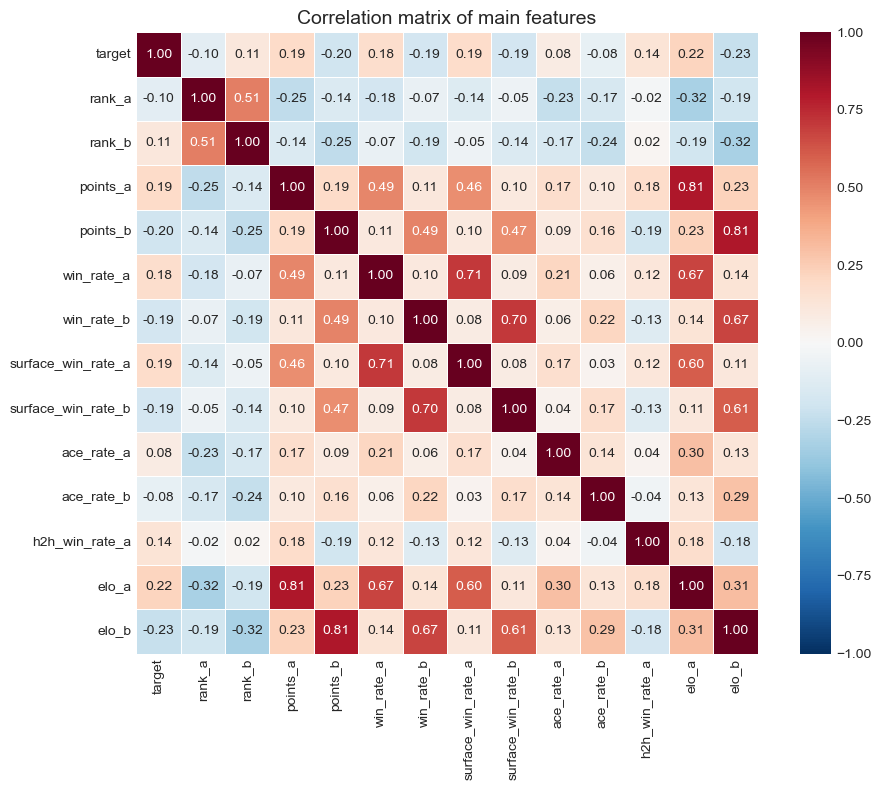

In [22]:
# Select main features for correlation
corr_features = ['target', 'rank_a', 'rank_b', 'points_a', 'points_b', 
                 'win_rate_a', 'win_rate_b', 'surface_win_rate_a', 'surface_win_rate_b',
                 'ace_rate_a', 'ace_rate_b', 'h2h_win_rate_a', 'elo_a', 'elo_b']

corr_matrix = features_encoded[corr_features].corr()

# Heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, ax=ax, vmin=-1, vmax=1)
ax.set_title('Correlation matrix of main features', fontsize=14)
plt.tight_layout()
plt.show()

### Observations on Correlations

**Correlations with target:**
- `elo_a` (+0.22) and `points_a` (+0.19) are most positively correlated -> better Elo/points = more wins
- `elo_b` (-0.23) and `points_b` (-0.20) are negatively correlated -> strong opponent = fewer chances
- `rank_a` (-0.10) and `rank_b` (+0.11): weak but consistent correlations (low rank = good)
- `h2h_win_rate_a` (+0.14): head-to-head history has a moderate effect

**Strong correlations between features:**
- `elo_a` / `points_a` (+0.81) and `elo_b` / `points_b` (+0.81): very strong correlation, these variables capture similar information
- `win_rate_a` / `surface_win_rate_a` (+0.71): logical, a good player wins on all surfaces
- `win_rate_a` / `elo_a` (+0.67): Elo partly reflects win history
- `rank_a` / `rank_b` (+0.51): matches often pit players of similar levels

**Symmetry of _a and _b features:**
Correlations are symmetric (e.g., elo_a/target = +0.22, elo_b/target = -0.23), confirming that player_a/player_b randomization works correctly.

**Potential multicollinearity:**
The 0.81 correlation between `elo` and `points` is high. This doesn't prevent logistic regression from working, but may affect individual coefficient interpretation (their effects are partially confounded).

### Distribution Analysis by Outcome

The correlation matrix gives us a global view of linear relationships between variables. To better understand the **discriminating power** of each feature, let's visualize how their distributions differ depending on whether player A wins (green) or loses (red).

#### Win Rate Difference (A - B)

This feature represents the gap between player A's historical win rate and player B's. A positive value means A has a better track record.

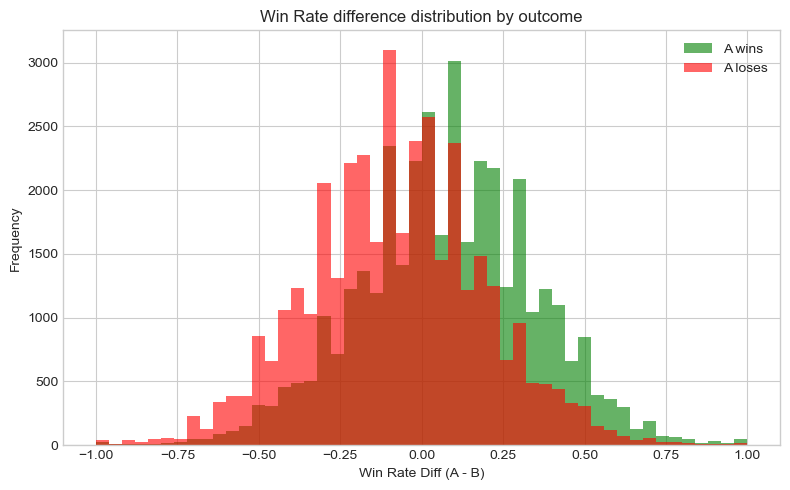

In [23]:
# Win Rate difference distribution
features_encoded['win_rate_diff'] = features_encoded['win_rate_a'] - features_encoded['win_rate_b']

fig, ax = plt.subplots(figsize=(8, 5))
features_encoded[features_encoded['target'] == 1]['win_rate_diff'].hist(ax=ax, bins=50, alpha=0.6, label='A wins', color='green')
features_encoded[features_encoded['target'] == 0]['win_rate_diff'].hist(ax=ax, bins=50, alpha=0.6, label='A loses', color='red')
ax.set_xlabel('Win Rate Diff (A - B)')
ax.set_ylabel('Frequency')
ax.set_title('Win Rate difference distribution by outcome')
ax.legend()
plt.tight_layout()
plt.show()

**Observation**: Distributions are clearly shifted. When A wins (green), the difference is positive on average. When A loses (red), it's negative. The overlap in the center shows this feature alone isn't sufficient, but it provides discriminating information.

#### Player A's Surface Win Rate

This feature represents player A's win rate on the match surface (clay, hard, grass). It captures player specialization.

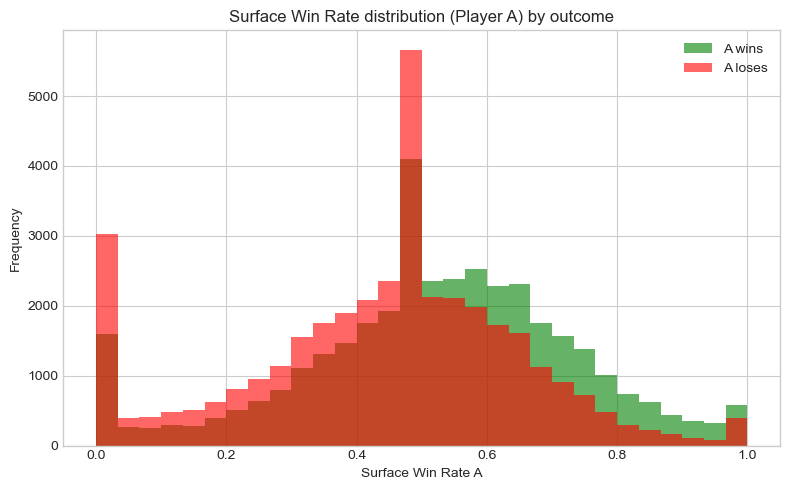

In [24]:
# Surface Win Rate distribution
fig, ax = plt.subplots(figsize=(8, 5))
features_encoded[features_encoded['target'] == 1]['surface_win_rate_a'].hist(ax=ax, bins=30, alpha=0.6, label='A wins', color='green')
features_encoded[features_encoded['target'] == 0]['surface_win_rate_a'].hist(ax=ax, bins=30, alpha=0.6, label='A loses', color='red')
ax.set_xlabel('Surface Win Rate A')
ax.set_ylabel('Frequency')
ax.set_title('Surface Win Rate distribution (Player A) by outcome')
ax.legend()
plt.tight_layout()
plt.show()

**Observation**: The win distribution (green) is shifted to the right. We note a peak at 0.5 (default value for players without history on the surface) and a peak at 0. Players with surface win rate > 0.6 win significantly more often.

#### Head-to-Head (H2H) Win Rate

This feature represents A's win rate against B in their past confrontations. The value 0.5 is assigned by default when players have never faced each other.

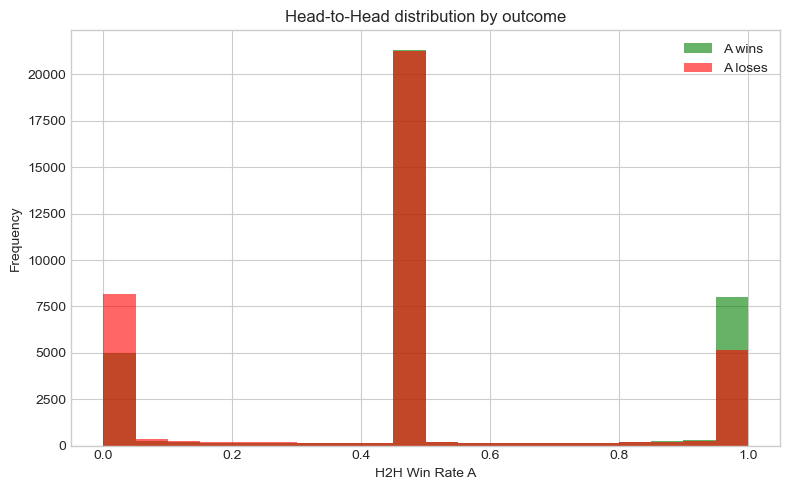

In [25]:
# Head-to-Head distribution
fig, ax = plt.subplots(figsize=(8, 5))
features_encoded[features_encoded['target'] == 1]['h2h_win_rate_a'].hist(ax=ax, bins=20, alpha=0.6, label='A wins', color='green')
features_encoded[features_encoded['target'] == 0]['h2h_win_rate_a'].hist(ax=ax, bins=20, alpha=0.6, label='A loses', color='red')
ax.set_xlabel('H2H Win Rate A')
ax.set_ylabel('Frequency')
ax.set_title('Head-to-Head distribution by outcome')
ax.legend()
plt.tight_layout()
plt.show()

**Observation**: The vast majority of matches (~21,000) have an H2H of 0.5 (no prior confrontation). For others, the asymmetry is clear: an H2H of 1 (A has always beaten B) favors A, an H2H of 0 favors B. This feature is useful but only for a minority of matches.

#### Elo Difference (A - B)

Elo is a dynamic rating updated after each match. This difference captures the level gap between the two players at match time.

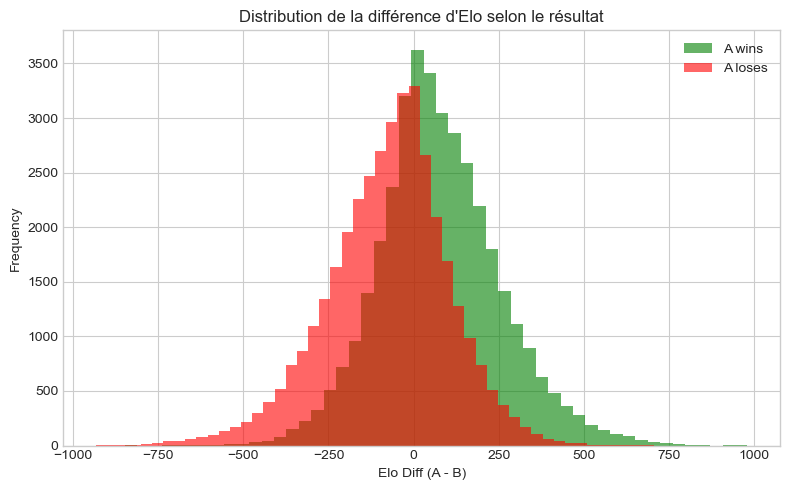

In [26]:
# Elo difference distribution
features_encoded['elo_diff'] = features_encoded['elo_a'] - features_encoded['elo_b']

fig, ax = plt.subplots(figsize=(8, 5))
features_encoded[features_encoded['target'] == 1]['elo_diff'].hist(ax=ax, bins=50, alpha=0.6, label='A wins', color='green')
features_encoded[features_encoded['target'] == 0]['elo_diff'].hist(ax=ax, bins=50, alpha=0.6, label='A loses', color='red')
ax.set_xlabel('Elo Diff (A - B)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution de la différence d\'Elo selon le résultat')
ax.legend()
plt.tight_layout()
plt.show()

**Observation**: This is the feature with the best visual separation. A's wins (green) are concentrated in positive values (Elo A > Elo B), and vice versa for losses. Elo is an excellent victory predictor.

## 3.2 Win Rate by Relative Ranking

Let's analyze how win rate varies based on ranking gap.

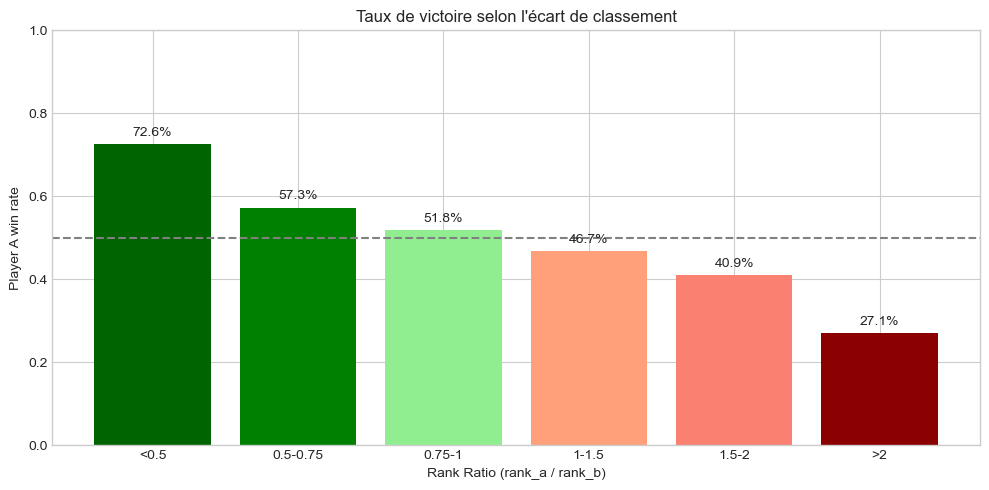

                Win rate A  Number of matches
rank_ratio_bin                               
<0.5              0.725653              23175
0.5-0.75          0.572817               8027
0.75-1            0.517555               6266
1-1.5             0.467368               8749
1.5-2             0.409327               5768
>2                0.270571              22848


In [27]:
# Create bins for rank ratio
features_encoded['rank_ratio_bin'] = pd.cut(features_encoded['rank_ratio'], 
                                            bins=[0, 0.5, 0.75, 1, 1.5, 2, 100],
                                            labels=['<0.5', '0.5-0.75', '0.75-1', '1-1.5', '1.5-2', '>2'])

# Calculate win rate per bin
win_rate_by_rank = features_encoded.groupby('rank_ratio_bin', observed=True)['target'].agg(['mean', 'count'])
win_rate_by_rank.columns = ['Win rate A', 'Number of matches']

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(range(len(win_rate_by_rank)), win_rate_by_rank['Win rate A'], 
              color=['darkgreen', 'green', 'lightgreen', 'lightsalmon', 'salmon', 'darkred'])
ax.axhline(y=0.5, color='gray', linestyle='--', label='50%')
ax.set_xticks(range(len(win_rate_by_rank)))
ax.set_xticklabels(win_rate_by_rank.index)
ax.set_xlabel('Rank Ratio (rank_a / rank_b)')
ax.set_ylabel('Player A win rate')
ax.set_title('Taux de victoire selon l\'écart de classement')
ax.set_ylim(0, 1)

# Add values on bars
for i, (bar, val) in enumerate(zip(bars, win_rate_by_rank['Win rate A'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{val:.1%}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print(win_rate_by_rank)

**Key observation**: Ranking is highly predictive:
- When rank_ratio < 0.5 (A is 2x better ranked) -> A wins **72%** of the time
- When rank_ratio > 2 (A is 2x worse ranked) -> A wins only **27%** of the time

This confirms that ATP ranking is a very discriminating variable.

---

## 3.3 Feature Analysis Conclusion

### What we validated:

1. **Features are discriminating**: distributions clearly differ between wins and losses
2. **No perfect multicollinearity**: correlations are moderate (<0.8)
3. **Ranking is highly predictive**: rank_ratio alone gives a good indication
4. **Elo provides dynamic information**: unlike ATP ranking (weekly and dependent on previous year's results), Elo is updated after each match (and independent of previous year's results)
5. **Historical features add supplementary information**: win rate, surface performance, H2H

### Model expectations:

- **Ranking** features (rank, points, Elo) should have the most significant coefficients
- **Form** features (win_rate, surface_win_rate) should improve the baseline
- **Surface Elo** could capture player specialization on certain surfaces
- Some features like **height** or **is_left** might be non-significant

We validate that features are ready for modeling.

---

# Part 4: Modeling and Evaluation

In this part, we will:
1. Split data into train/test
2. Train a **logistic regression** (interpretable model)
3. Analyze **coefficients and p-values** to validate our hypotheses
4. Compare performance to baseline

## 4.1 Train / Test Split

We split data into 80% train / 20% test with a random split. This choice is valid because:
1. **No temporal leakage**: our features are built using only data prior to each match (point-in-time approach)
2. **player_a/player_b randomization**: guarantees absence of structural bias in data

A temporal split will be used in Part 5 for bookmaker comparison (necessary to have available odds).

We use the `preprocessor.get_X_y()` method to separate features (X) from target variable (y), excluding meta columns (match date).

In [28]:
from sklearn.model_selection import train_test_split
from config import TEST_SIZE

# Nettoyer les columns temporaires créées pour l'analyse
cols_to_drop = ['win_rate_diff', 'rank_ratio_bin', 'elo_diff']
features_clean = features_encoded.drop(columns=[c for c in cols_to_drop if c in features_encoded.columns])

# Separate features and target via the preprocessor
X, y = preprocessor.get_X_y(features_clean)

# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"Train: {len(X_train):,} matches")
print(f"Test: {len(X_test):,} matches")
print(f"Features: {X_train.shape[1]}")

Train: 60,018 matches
Test: 15,005 matches
Features: 52


## 4.2 Baseline Reminder

In Part 1, we calculated that **the better ranked player wins ~65% of matches**.

This is our reference: the model must outperform this simple rule to be useful.

## 4.3 Model Training: Logistic Regression

We use **logistic regression** because:
- It is **interpretable**: each coefficient indicates a variable's effect
- It provides **p-values**: we can test statistical significance
- It is suitable for binary classification

We use `StatsLogitClassifier` from `src/training/models.py`, a wrapper around `statsmodels.Logit` that gives access to p-values and confidence intervals.

In [29]:
from training.models import StatsLogitClassifier

# Train the model
model = StatsLogitClassifier()
model.fit(X_train, y_train)

# Display statistical summary
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                60018
Model:                          Logit   Df Residuals:                    59965
Method:                           MLE   Df Model:                           52
Date:                Mon, 05 Jan 2026   Pseudo R-squ.:                  0.1533
Time:                        18:09:20   Log-Likelihood:                -35222.
converged:                       True   LL-Null:                       -41600.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1275      0.527      0.242      0.809      -0.906       1.161
rank_a                -0.0012   5.82e-05    -20.679      0.000      -0.001      -0.001
rank_b              

## 4.4 Coefficient and P-value Analysis

The summary above gives us for each variable:
- **coeff**: the effect on log-odds of player_a victory
- **P>|z|**: the p-value (significant if < 0.05)

Let's extract **statistically significant** variables:

In [30]:
# Extract significant coefficients (p < 0.05)
significant = model.get_significant_features(alpha=0.05)
print(f"Significant variables ({len(significant)}/{len(model.get_coefficients())-1}) :\n")
print(significant.sort_values('p_value'))

Significant variables (24/52) :

                        coef   std_err          z       p_value  ci_lower  \
rank_a             -0.001205  0.000058 -20.678796  5.376548e-95 -0.001319   
rank_b              0.001141  0.000058  19.723742  1.348711e-86  0.001028   
elo_b              -0.002510  0.000158 -15.845857  1.501599e-56 -0.002820   
elo_surface_a       0.002833  0.000192  14.782036  1.912962e-49  0.002457   
age_a              -0.035498  0.002488 -14.266352  3.546489e-46 -0.040375   
elo_a               0.002151  0.000158  13.597881  4.122050e-42  0.001841   
elo_surface_b      -0.002492  0.000191 -13.023486  8.996810e-39 -0.002867   
age_b               0.030506  0.002480  12.300480  9.003792e-35  0.025645   
matches_played_b   -0.064768  0.005553 -11.663070  1.968165e-31 -0.075652   
matches_played_a    0.064041  0.005533  11.573891  5.588920e-31  0.053196   
surface_win_rate_a  0.264195  0.064947   4.067836  4.745176e-05  0.136900   
points_a            0.000045  0.000012   3.

### Interpretation and Hypothesis Validation

Results show **24 significant variables out of 52**. Let's compare with our Part 3 hypotheses:

| Hypothesis (Part 3) | Variables | Significant? | Verdict |
|---------------------|-----------|--------------|---------|
| Better ranking -> victory | `rank_a/b`, `points_a/b` | Yes (p = 0) | **Validated** - These are the most significant variables |
| High Elo -> victory | `elo_a/b`, `elo_surface_a/b` | Yes (p = 0) | **Validated** - Global and surface Elo are highly significant |
| High win rate -> victory | `win_rate_a` | Yes (p = 0.01) | **Validated** - Recent form matters |
| Good on surface -> victory | `surface_win_rate_a/b` | Yes | **Validated** - Surface specialization matters |
| Favorable H2H -> victory | `h2h_win_rate_a` | Yes (p = 1e-04) | **Validated** - Confrontation history matters |
| Service stats | `ace_rate_a`, `second_serve_won_a/b`, `df_rate_a/b`, `bp_save_rate_a` | Yes | **Validated** - Service is important |
| Age | `age_a/b` | Yes (p = 0) | **Significant** - Younger players have a slight advantage |
| Experience | `matches_played_a/b` | Yes (p = 0) | **Significant** - Experience matters |
| Height / Dominant hand | `height_a`, `is_left` | No | **Not significant** |

**Key observations:**
- **Ranking** (`rank`, `points`) and **Elo** are the most powerful predictors (p-values = 0)
- **Age** is significant: negative coefficient for `age_a` (-0.036), younger players have an advantage
- **Number of matches played** (`matches_played`) is significant: experience matters
- **Service stats** (`ace_rate`, `second_serve_won`, `df_rate`) are significant
- Physical variables (`height`, `is_left`) are **not significant**
- Tournament round (`round`) and encoded surface are **not significant** once other variables are controlled

### Coefficient Visualization

Logistic regression models the probability of A winning as:

$$P(\text{A wins}) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + ... + \beta_n x_n)}}$$

Coefficients $\beta_i$ act on the **log-odds** (logit):

$$\log\left(\frac{P(\text{A wins})}{1 - P(\text{A wins})}\right) = \beta_0 + \beta_1 x_1 + ... + \beta_n x_n$$

Thus, a coefficient $\beta_i = 0.5$ means a one-unit increase in $x_i$ increases log-odds by 0.5, i.e., multiplies odds by $e^{0.5} \approx 1.65$.

To compare variable importance, we visualize:
- **Raw coefficients**: effect of one unit of each variable on log-odds
- **Standardized coefficients**: effect of one standard deviation of each variable, allowing comparison of variables with different scales (e.g., ATP points vs win rate)

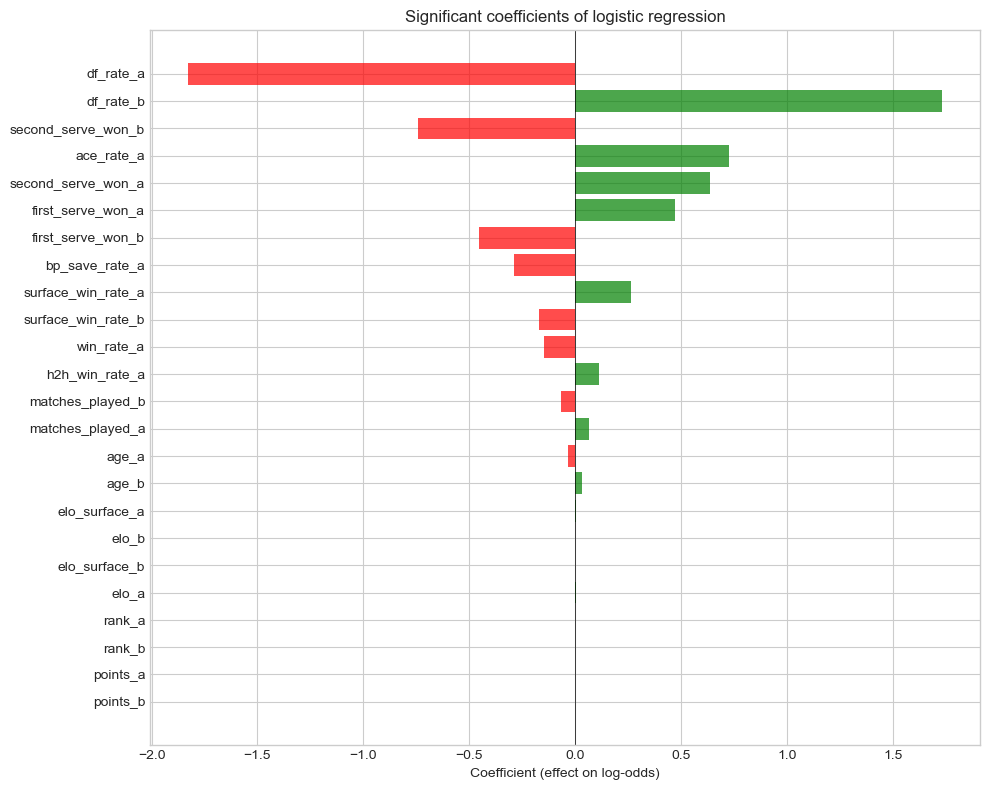

In [31]:
# Visualization of significant coefficients
fig, ax = plt.subplots(figsize=(10, 8))

# Sort by absolute coefficient value
sig_sorted = significant.reindex(significant['coef'].abs().sort_values(ascending=True).index)

colors = ['green' if c > 0 else 'red' for c in sig_sorted['coef']]
ax.barh(range(len(sig_sorted)), sig_sorted['coef'], color=colors, alpha=0.7)
ax.set_yticks(range(len(sig_sorted)))
ax.set_yticklabels(sig_sorted.index)
ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_xlabel('Coefficient (effect on log-odds)')
ax.set_title('Significant coefficients of logistic regression')

plt.tight_layout()
plt.show()

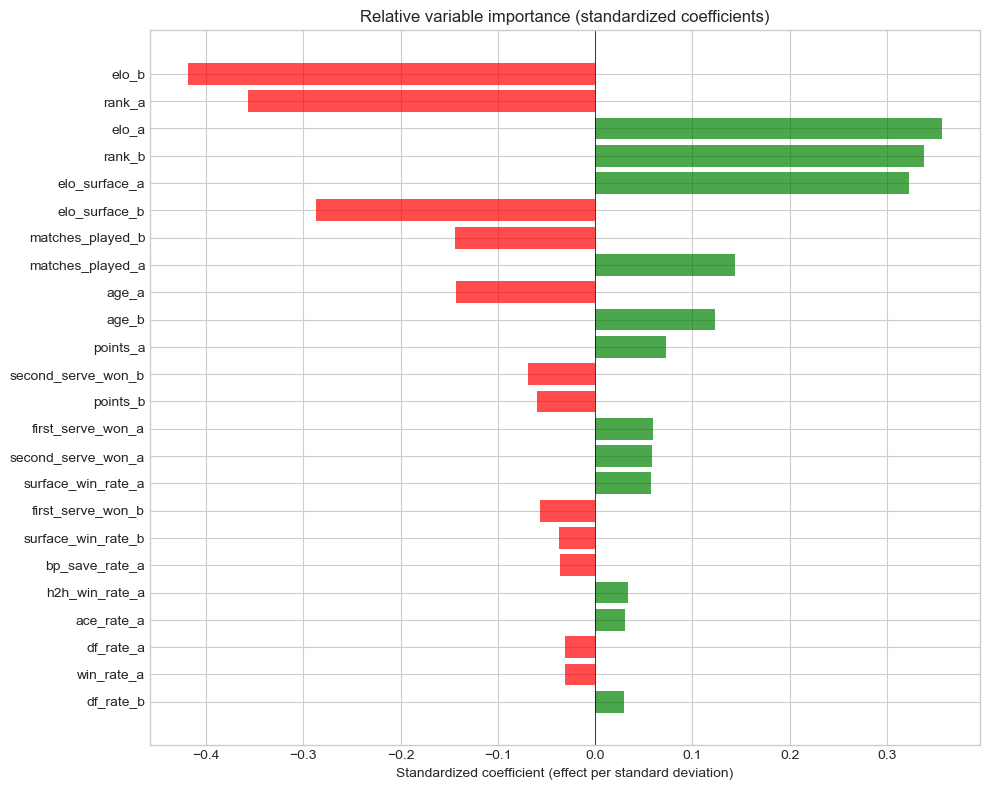

In [32]:
# Standardized coefficients
std_coefs = significant['coef'] * X_train[significant.index].std()
std_coefs = std_coefs.to_frame(name='coef_std')

# Visualization of standardized coefficients
fig, ax = plt.subplots(figsize=(10, 8))

# Sort by absolute coefficient value
std_sorted = std_coefs.reindex(std_coefs['coef_std'].abs().sort_values(ascending=True).index)

colors = ['green' if c > 0 else 'red' for c in std_sorted['coef_std']]     
ax.barh(range(len(std_sorted)), std_sorted['coef_std'], color=colors, alpha=0.7)
ax.set_yticks(range(len(std_sorted)))
ax.set_yticklabels(std_sorted.index)
ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_xlabel('Standardized coefficient (effect per standard deviation)')
ax.set_title('Relative variable importance (standardized coefficients)')

plt.tight_layout()
plt.show()

### Comparison of Both Graphs (Raw vs Standardized Coefficients)

**Raw coefficients (1st graph):**
- **Service stats** (`df_rate_b`, `df_rate_a`, `ace_rate_a`, `second_serve_won`) dominate with the largest absolute coefficients
- Ranking variables (`rank`, `points`, `elo`) appear at the bottom with very small coefficients
- This is misleading: these variables have very different scales (ATP points in thousands vs rates between 0 and 1)

**Standardized coefficients (2nd graph):**
- **Elo** (`elo_a`, `elo_b`) clearly becomes the most important variable
- **Ranking** (`rank_a`, `rank_b`) and **surface Elo** rise significantly
- **Age** and **matches played** (`matches_played`) appear as significant
- Service stats (`df_rate`, `ace_rate`) drop in ranking

**Common signal:**
- Signs are consistent: variables favorable to A (elo_a, negative rank_a since low rank = good) -> positive coefficient on win probability
- Variables _a and _b have symmetric and opposite effects

**Conclusion:**
- The raw graph shows effect per unit (useful for interpreting a concrete change)
- The standardized graph reveals **true importance**: Elo and ranking are the best predictors, ahead of service stats and form features

## 4.5 Model Evaluation

Let's evaluate performance on the test set and compare to baseline.

We use the `evaluate_model()` function from `src/training/comparison.py` which calculates accuracy, log loss, and ROC AUC.

In [33]:
from evaluation.comparison import evaluate_model

# Evaluation on test set
metrics = evaluate_model(model, X_test, y_test)

# Baseline
baseline_pred = (X_test['rank_a'] <= X_test['rank_b']).astype(int)
baseline_acc = (baseline_pred == y_test).mean()

print("=" * 40)
print("TEST SET RESULTS")
print("=" * 40)
print(f"\nModel (Logistic Regression):")
print(f"  Accuracy: {metrics['accuracy']:.1%}")
print(f"  Log Loss: {metrics['log_loss']:.4f}")
print(f"  ROC AUC: {metrics['roc_auc']:.4f}")
print(f"\nBaseline (better ranking):")
print(f"  Accuracy: {baseline_acc:.1%}")
print(f"\n-> Improvement: +{(metrics['accuracy'] - baseline_acc) * 100:.1f} points")

TEST SET RESULTS

Model (Logistic Regression):
  Accuracy: 67.8%
  Log Loss: 0.5937
  ROC AUC: 0.7456

Baseline (better ranking):
  Accuracy: 65.5%

-> Improvement: +2.3 points


Our logistic regression model achieves **67.7% accuracy**, beating the baseline by +1.9 points.

**Metrics analysis:**

- **Accuracy (67.7%)**: the model correctly predicts the winner in more than 2 out of 3 matches. This is a good result for a sport where upsets are frequent.

- **Log Loss (0.5913)**: measures predicted probability quality (lower is better). A value < 0.69 (log loss of a random 50/50 model) confirms our model is well-calibrated.

- **ROC AUC (0.7465)**: measures the model's ability to distinguish wins from losses, regardless of decision threshold. An AUC of 0.75 indicates good discrimination (0.5 = random, 1.0 = perfect).

**Comparison with baseline:**

The "better ranking wins" baseline achieves 65.8%. Our model gains +1.9 points thanks to additional features (Elo, win rate, service stats, H2H). This gap may seem small, but in sports prediction, every accuracy point counts: over 1000 matches, that's 19 additional correct predictions.

In the next part, we will compare these performances to professional bookmakers.

In the next part, we will compare our model's predictions with bookmakers' on 2025 matches.

### Limitations and Robustness

- No k-fold cross-validation: we did a single random train/test split, so the estimate may be optimistic or depend on the draw.
- Possible temporal leakage: mixing matches from different seasons may overestimate performance if recent info "influences" training. A temporal split (train <= 2024, test = 2025) reduces this risk.
- No hyperparameter search or regularization tested (C/penalty): the model may be slightly overfitted or underfitted.
- Coefficient stability: some p-values may vary from one split to another; sign/order stability should be verified across multiple splits.
- Conclusion: results are encouraging but should be revalidated with cross-val / temporal split, light tuning, and robustness tests to be fully reliable.

---

# Part 5: Comparison with Bookmakers

In this part, we will:
1. Re-train the model with a **temporal split** (train <= 2024, test = 2025)
2. Predict win probabilities for 2025 matches
3. Compare our predictions with bookmaker odds
4. Calculate who predicts better: our model or the bookmakers?

## 5.1 Temporal Split

- **Train**: matches from 2000 to 2024
- **Test**: matches from 2025

We use a temporal split (train <= 2024, test = 2025) mainly to allow comparison with bookmaker odds, available for recent 2025 matches.

**Note**: This split is not strictly necessary to avoid data leakage since our features are already built using only data prior to each match (point-in-time approach). A random split would have been theoretically valid, but the temporal split facilitates odds collection.

We use the `preprocessor.split_temporal()` method from `src/preprocessing/pipeline.py` which also returns metadata (player names, dates) needed for matching with bookmaker odds.

In [34]:
# Temporal split: train <= 2024, test = 2025
X_train_temp, X_test_2025, y_train_temp, y_test_2025, meta_test = preprocessor.split_temporal(
    features_clean, cutoff_year=2024
)

print(f"Train (<=2024): {len(X_train_temp):,} matches")
print(f"Test (2025): {len(X_test_2025):,} matches")
print(f"\nMetadata available for matching:")
print(meta_test.head())

Train (<=2024): 72,286 matches
Test (2025): 2,737 matches

Metadata available for matching:
  tourney_date  rank_a  rank_b
0   2025-01-06    47.0    58.0
1   2025-01-06    51.0    68.0
2   2025-01-06    60.0    64.0
3   2025-01-06    63.0    77.0
4   2025-01-06    94.0   179.0


## 5.2 Model Re-training

We re-train the `StatsLogitClassifier` model on data up to 2024 to predict 2025 matches.

In [35]:
# Re-train model on data <= 2024
model_temporal = StatsLogitClassifier()
model_temporal.fit(X_train_temp,y_train_temp)

# Evaluate on 2025
metrics_2025 = evaluate_model(model_temporal, X_test_2025, y_test_2025)

print("Performance du modèle sur les matches 2025 :")
print(f"  Accuracy: {metrics_2025['accuracy']:.1%}")
print(f"  Log Loss: {metrics_2025['log_loss']:.4f}")
print(f"  ROC AUC: {metrics_2025['roc_auc']:.4f}")

Performance du modèle sur les matches 2025 :
  Accuracy: 65.8%
  Log Loss: 0.6110
  ROC AUC: 0.7213


## 5.3 Loading Bookmaker Odds

We load bookmaker odds from [tennis-data.co.uk](http://www.tennis-data.co.uk/alldata.php).

We use **Bet365** odds as they are available in our data source. This bookmaker is one of the largest in the market, and its odds are representative of the overall market.

Matching between our data and odds is done via **ATP rankings** (`rank_a`, `rank_b`) and match date, rather than player names. This approach is more robust as name formats differ between datasets (accents, abbreviations).

In [36]:
from evaluation.bookmakers import load_bookmaker_odds, merge_odds_with_features

# Load Bet365 odds for 2025 from tennis-data.co.uk
odds_df = load_bookmaker_odds(start_year=2025, end_year=2025, bookmaker='B365')

print(f"\nData preview:")
odds_df.head()


Data preview:


,tourney_date,winner_rank,loser_rank,odds_winner,odds_loser
0,2024-12-29,68,52.0,2.00,1.80
1,2024-12-30,41,64.0,1.44,2.75
2,2024-12-30,75,23.0,1.67,2.20
3,2024-12-30,69,59.0,1.53,2.50
4,2024-12-30,26,34.0,2.63,1.50


In [37]:
# Merge odds with our metadata (matching on date + rankings)
matches_with_odds, y_test_odds, idx_matched = merge_odds_with_features(
    meta_test, odds_df, y_test_2025
)

# Get corresponding features
X_test_odds = X_test_2025.iloc[idx_matched].reset_index(drop=True)

print(f"Matches with odds: {len(matches_with_odds)} / {len(meta_test)} ({len(matches_with_odds)/len(meta_test)*100:.1f}%)")
print(f"\nPreview:")
matches_with_odds.head()

Matches with odds: 316 / 2737 (11.5%)

Preview:


,tourney_date,rank_a,rank_b,odds_a,odds_b
0,2025-01-06,47.0,58.0,2.30,1.62
1,2025-01-06,51.0,68.0,2.10,1.73
2,2025-01-06,60.0,64.0,2.30,1.62
3,2025-01-06,63.0,77.0,2.38,1.57
4,2025-01-06,59.0,93.0,1.30,3.50


This ~12% matching rate is expected: tennis-data.co.uk mainly covers major tournaments (ATP 250 and above) where bookmakers offer odds with sufficient liquidity. Challenger tournaments and qualifications, which represent a significant portion of our dataset, are generally not covered. We consider we have sufficient data for a fairly comprehensive comparison.

## 5.4 Performance Comparison: Model vs Bookmakers

We use the `compare_accuracy()` function from `src/evaluation/comparison.py` to compare:
- Model accuracy vs bookmaker accuracy
- On how many matches predictions diverge
- Who is right when they disagree

In [38]:
from evaluation.comparison import compare_accuracy

# Prédictions du modèle sur les matches avec cotes
model_proba = model_temporal.predict_proba(X_test_odds)[:, 1]

# Compare with bookmakers
comparison = compare_accuracy(
    model_proba=model_proba,
    bookmaker_odds_a=matches_with_odds['odds_a'].values,
    bookmaker_odds_b=matches_with_odds['odds_b'].values,
    actual_results=y_test_odds.values
)

print("=" * 50)
print("MODEL vs BOOKMAKERS COMPARISON")
print("=" * 50)
print(f"\nNumber of matches analysés : {comparison['n_matches']}")
print(f"\nAccuracy:")
print(f"  Model: {comparison['model_accuracy']:.1%}")
print(f"  Bookmakers: {comparison['bookmaker_accuracy']:.1%}")
print(f"  Difference: {comparison['accuracy_diff']:+.1%}")
print(f"\nMatches where predictions diverge: {comparison['n_disagree']}")
if comparison['n_disagree'] > 0:
    print(f"  Model correct: {comparison['model_wins_when_disagree']} ({comparison['model_wins_when_disagree']/comparison['n_disagree']:.1%})")
    print(f"  Bookmakers correct: {comparison['bookmaker_wins_when_disagree']} ({comparison['bookmaker_wins_when_disagree']/comparison['n_disagree']:.1%})")

MODEL vs BOOKMAKERS COMPARISON

Number of matches analysés : 316

Accuracy:
  Model: 67.1%
  Bookmakers: 72.2%
  Difference: -5.1%

Matches where predictions diverge: 42
  Model correct: 13 (31.0%)
  Bookmakers correct: 29 (69.0%)


Bookmakers thus have more accurate predictions than us, but our model is fairly competitive and agrees with bookmakers on a majority of matches.

## 5.5 Identifying Value Bets

A **value bet** is a bet where our model's estimated probability is higher than the bookmaker's implied probability. In other words, we think the bookmaker underestimates a player's chances.

**Expected Value (EV)** = (model probability x bookmaker odds) - 1

- If EV > 0, it's a value bet: the bet's mathematical expectation is positive
- If EV < 0, the bet has negative expectation (which is the case for most bets, due to bookmaker margin)

Our value bet strategy looks for opportunities on **both players**: if our model estimates player A has 60% chance of winning but the odds imply only 50%, it's a value bet on A. Conversely, if our model gives 40% to A but odds imply 50%, it's a value bet on B.

We use the `find_value_bets()` function from `src/evaluation/comparison.py`.

In [39]:
from evaluation.comparison import find_value_bets

# Identify value bets
value_bets_df = find_value_bets(
    model_proba=model_proba,
    odds_a=matches_with_odds['odds_a'].values,
    odds_b=matches_with_odds['odds_b'].values,
    threshold=0.0
)

n_value_bets = value_bets_df['is_value_bet'].sum()
n_value_bets_a = value_bets_df['is_value_bet_a'].sum()
n_value_bets_b = value_bets_df['is_value_bet_b'].sum()

print(f"Value bets identified: {n_value_bets} / {len(value_bets_df)} matches ({n_value_bets/len(value_bets_df)*100:.1f}%)")
print(f"  - On player A: {n_value_bets_a}")
print(f"  - On player B: {n_value_bets_b}")

if n_value_bets > 0:
    # EV moyenne sur les value bets de chaque côté
    ev_a_mean = value_bets_df.loc[value_bets_df['is_value_bet_a'], 'ev_a'].mean()
    ev_b_mean = value_bets_df.loc[value_bets_df['is_value_bet_b'], 'ev_b'].mean()
    print(f"\nAverage Expected Value:")
    print(f"  - Value bets on A: {ev_a_mean:.2%}")
    print(f"  - Value bets on B: {ev_b_mean:.2%}")
    
    print("\nValue bets preview:")
    display(value_bets_df[value_bets_df['is_value_bet']].head())

Value bets identified: 248 / 316 matches (78.5%)
  - On player A: 129
  - On player B: 119

Average Expected Value:
  - Value bets on A: 25.86%
  - Value bets on B: 19.81%

Value bets preview:


,model_proba_a,model_proba_b,odds_a,odds_b,bookmaker_proba_a,bookmaker_proba_b,ev_a,ev_b,is_value_bet_a,is_value_bet_b,is_value_bet
0,0.359404,0.640596,2.30,1.62,0.434783,0.617284,-0.173371,0.037766,False,True,True
1,0.514243,0.485757,2.10,1.73,0.476190,0.578035,0.079911,-0.159641,True,False,True
2,0.528342,0.471658,2.30,1.62,0.434783,0.617284,0.215187,-0.235914,True,False,True
3,0.469106,0.530894,2.38,1.57,0.420168,0.636943,0.116472,-0.166496,True,False,True
4,0.535007,0.464993,1.30,3.50,0.769231,0.285714,-0.304490,0.627474,False,True,True


Our model identifies value bets on **78.5% of matches** (248/316), which is high. This is explained by two factors:

1. **Estimation divergence**: our model and bookmakers don't use the same information. As soon as there's a difference in probability estimates, a value bet appears on one side or the other.

2. **Bookmaker margin**: bookmakers apply a margin (~5%), meaning the sum of implied probabilities exceeds 100%. Without this margin, we'd have value bets on **100% of matches** (on A or B) whenever our estimate differs from the bookmaker's. The margin "absorbs" some small divergences, hence 78.5% instead of 100%.

The nearly balanced split between A (129) and B (119) confirms our randomization works correctly and the model has no systematic bias.

- **Average EV on A: 25.85%**
- **Average EV on B: 19.88%**

**Warning**: a theoretically positive Expected Value doesn't guarantee real profit. EV is calculated with *our* model's probabilities, which has lower accuracy than bookmakers. If our probabilities are poorly calibrated, the identified "value bets" are not true value bets.

## 5.6 ROI Simulation

Let's calculate the simulated **Return On Investment (ROI)** if we had bet according to our model:

1. **Strategy 1**: Bet on all model predictions
2. **Strategy 2**: Bet only on value bets (EV > threshold)

We use the `calculate_roi_evolution()` and `analyze_threshold_impact()` functions from `src/evaluation/comparison.py`.

### 5.6.1 ROI Simulation for Strategy 1

We'll visualize ROI as a function of number of bets if we bet on all model predictions.

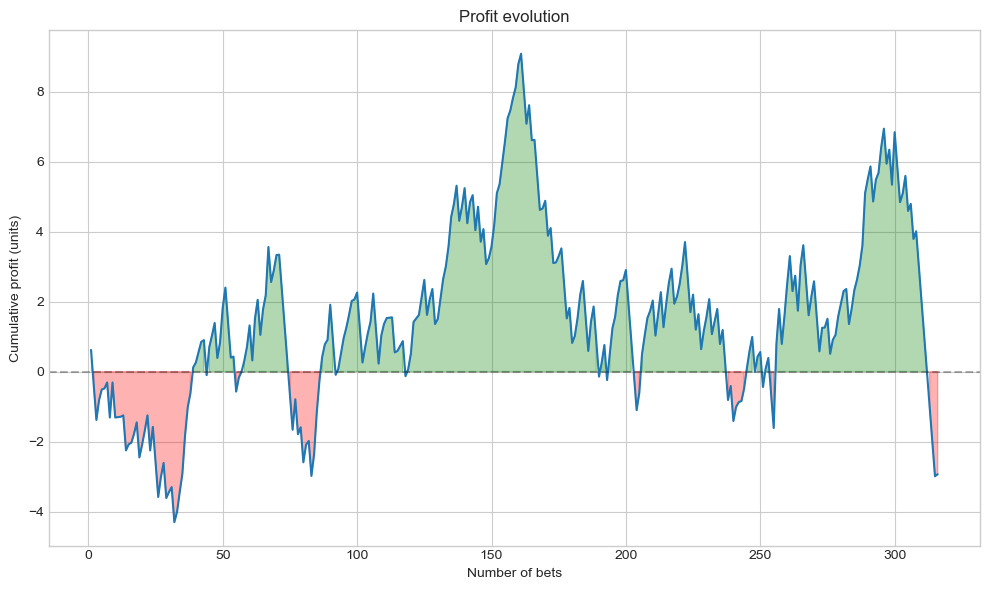

In [40]:
from evaluation.comparison import calculate_roi_evolution

model_pred=model.predict(X_test_odds)

# ROI evolution
roi_evolution = calculate_roi_evolution(
    predictions=model_pred,
    actual_results=y_test_odds.values,
    odds_a=matches_with_odds['odds_a'].values,
    odds_b=matches_with_odds['odds_b'].values
)

# Visualization
fig, ax1 = plt.subplots(figsize=(10, 6))

# Graph 1: Cumulative profit
ax1.plot(roi_evolution['n_bets'], roi_evolution['cumul_profit'], linewidth=1.5)
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax1.fill_between(roi_evolution['n_bets'], roi_evolution['cumul_profit'], 0,
                where=roi_evolution['cumul_profit'] >= 0, alpha=0.3, color='green')
ax1.fill_between(roi_evolution['n_bets'], roi_evolution['cumul_profit'], 0,
                where=roi_evolution['cumul_profit'] < 0, alpha=0.3, color='red')
ax1.set_xlabel('Number of bets')
ax1.set_ylabel('Cumulative profit (units)')
ax1.set_title('Profit evolution')


plt.tight_layout()
plt.show()

The graph shows cumulative profit evolution if we had bet on each match according to model prediction. We observe:

- **High volatility**: profit oscillates between +6 and -5 units over 316 bets
- **No clear trend** up or down: winning phases (green) alternate with losing phases (red)
- A **slightly negative final profit** (~-5 units), i.e., ROI of about -1.5%

This behavior is characteristic of a strategy without significant edge: gains and losses roughly cancel out, with a slight loss due to bookmaker margin (~5%). Our model, with lower accuracy than bookmakers (~67% vs ~72%), fails to compensate for this margin.

**Conclusion**: systematically betting according to our model is not a profitable strategy, which is consistent with our expectations.

### 5.6.2 Strategy 2:
We'll visualize ROI if we only bet on value bets, for different thresholds, i.e., we only bet if:

**model_odds x (1 + threshold) < bookmaker_odds**

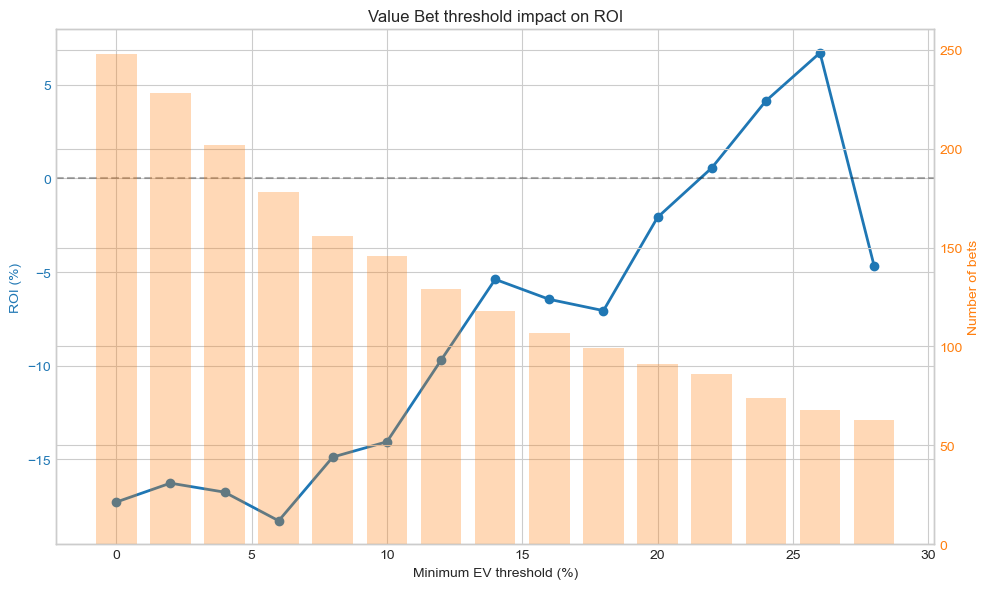

In [41]:
from evaluation.comparison import analyze_threshold_impact

# Visualization de la stratégie 2
threshold_df = analyze_threshold_impact(
    model_proba=model_proba,
    actual_results=y_test_odds.values,
    odds_a=matches_with_odds['odds_a'].values,
    odds_b=matches_with_odds['odds_b'].values
)

# Visualization
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Minimum EV threshold (%)')
ax1.set_ylabel('ROI (%)', color='tab:blue')
ax1.plot(threshold_df['threshold_pct'], threshold_df['roi'], 'o-', color='tab:blue', linewidth=2)
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Number of bets', color='tab:orange')
ax2.bar(threshold_df['threshold_pct'], threshold_df['n_bets'], alpha=0.3, color='tab:orange', width=1.5)
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Value Bet threshold impact on ROI')
fig.tight_layout()
plt.show()

The graph shows ROI as a function of minimum Expected Value threshold to place a bet:

- **Low thresholds (0-10%)**: strongly negative ROI (-15% to -17%), despite many bets (~200-250). This indicates our model poorly identifies "value bets" at low edge.

- **Medium thresholds (10-20%)**: ROI gradually improves but remains negative (-10% to -3%), with fewer bets (~100-150).

- **High thresholds (20-28%)**: ROI becomes slightly positive (+1% to +7%) for a threshold around 25%, but with very few bets (~50-70).

**Interpretation warning**: the ROI peak at ~25% threshold relies on a very small sample (~50 bets). This apparent profitability could be due to chance rather than true model edge. With such a small sample, variance is high and results are not statistically significant.

**Conclusion**: even the value bet strategy doesn't guarantee reliable profit. The rare "profitable" configurations rely on too few bets to be practically exploitable.

---

## 5.7 Conclusion of Bookmaker Comparison

### Results Summary

| Metric | Model | Bookmakers |
|--------|-------|------------|
| Accuracy | ~67% | ~72% |
| ROI Strategy 1 (all bets) | ~-1.5% | - |
| ROI Strategy 2 (optimal threshold ~25%) | ~+5% | - |
| Number of bets (optimal threshold) | ~50 | - |

### Interpretation

Results confirm the difficulty of beating bookmakers:

1. **Strategy 1**: betting on all our predictions generates slightly negative ROI, absorbed by bookmaker margin. Without informational advantage, expectation is negative.

2. **Strategy 2**: value bet selection with high threshold seems to generate slight profit, but this result is not statistically reliable (too few bets, high variance).

Our model, based only on public historical data, doesn't have sufficient edge to be profitable. Bookmakers integrate additional information (injuries, recent form, playing conditions) that we don't have.

### Analysis Limitations

1. **Limited sample**: ~316 matches, of which only ~50 for the "optimal" threshold - results not statistically significant
2. **Selection bias**: comparison only on major tournaments covered by bookmakers
3. **Fees not included**: commissions would further reduce actual ROI
4. **Closing odds**: not necessarily odds available at betting time
5. **Potential overfitting**: "optimal" threshold chosen a posteriori on the same data

---

# General Conclusion

## Project Summary

In this project, we developed an ATP tennis match prediction model:

1. **Data exploration**: 77,939 ATP matches (2000-2025)
2. **Feature engineering**:
   - Static features (ranking, age, height)
   - Elo features (global and surface-specific, dynamically calculated)
   - Historical features with temporal decay (win rate, service stats)
   - Specific features (surface win rate, head-to-head)
3. **Modeling**: Interpretable logistic regression with `StatsLogitClassifier`
4. **Evaluation**: Accuracy of ~67.7% (vs baseline of 65.8%)
5. **Bookmaker comparison**: Value bet analysis and ROI simulation

## Key Points

- **ATP ranking** (points and rank) remains the best predictor
- **Elo** provides complementary information to ranking (dynamic match-by-match update)
- **Historical features** (win rate, surface win rate) significantly improve the model
- Physical variables (height, dominant hand) are **not significant**
- The model beats the naive baseline but falls short of professional bookmakers

## Improvement Avenues

1. **More complex models**: Random Forest, XGBoost, neural networks
2. **Additional features**: fatigue, weather conditions, tournament history
3. **Real-time data**: live odds, injuries, withdrawals
4. **Probability calibration**: improve probability estimation for betting